In [118]:
import csv
import collections
import pandas as pd
import numpy as np
from sklearn import tree

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import random
from pprint import pprint
global FEATURE_TYPES


In [119]:
df = pd.read_csv('Job_Placement_Data.csv')
df = df.drop(["ssc_board","hsc_board","gender"], axis=1)
# df["status"] = pd.Categorical(df["status"]).codes
# df["work_experience"] = pd.Categorical(df["work_experience"]).codes
# df["gender"] = pd.Categorical(df["gender"]).codes
# df["specialisation"] = pd.Categorical(df["specialisation"]).codes
# df = df.drop("ssc_board", axis=1)
# df = df.drop("hsc_board", axis=1)
# df = df.drop("ssc_percentage",axis=1)
# df = df.drop(["hsc_percentage","hsc_subject","degree_percentage", "undergrad_degree"], axis=1)

In [120]:
df.head()

,ssc_percentage,hsc_percentage,hsc_subject,degree_percentage,undergrad_degree,work_experience,emp_test_percentage,specialisation,mba_percent,status
0,67.00,91.00,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed
1,79.33,78.33,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed
2,65.00,68.00,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed
3,56.00,52.00,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed
4,85.80,73.60,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed


In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ssc_percentage       215 non-null    float64
 1   hsc_percentage       215 non-null    float64
 2   hsc_subject          215 non-null    object 
 3   degree_percentage    215 non-null    float64
 4   undergrad_degree     215 non-null    object 
 5   work_experience      215 non-null    object 
 6   emp_test_percentage  215 non-null    float64
 7   specialisation       215 non-null    object 
 8   mba_percent          215 non-null    float64
 9   status               215 non-null    object 
dtypes: float64(5), object(5)
memory usage: 16.9+ KB


# Train Test Split

In [122]:
def Train_test_split(df, test_size):
    if isinstance(test_size,float):
        test_size = round(test_size*len(df))

    indices = df.index.tolist()
    test_indices = random.sample(population = indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    # val_df = train_df

    return train_df, test_df

In [123]:
random.seed(0)
train_df, test_df = Train_test_split(df, test_size = 0.1)

In [124]:
# sns.lmplot(data=train_df, x="work_experience", y="mba_percent", hue="status")

# Helper Functions

In [125]:
data  = train_df.values
data[:5]

array([[67.0, 91.0, 'Commerce', 58.0, 'Sci&Tech', 'No', 55.0, 'Mkt&HR',
        58.8, 'Placed'],
       [79.33, 78.33, 'Science', 77.48, 'Sci&Tech', 'Yes', 86.5,
        'Mkt&Fin', 66.28, 'Placed'],
       [65.0, 68.0, 'Arts', 64.0, 'Comm&Mgmt', 'No', 75.0, 'Mkt&Fin',
        57.8, 'Placed'],
       [56.0, 52.0, 'Science', 52.0, 'Sci&Tech', 'No', 66.0, 'Mkt&HR',
        59.43, 'Not Placed'],
       [85.8, 73.6, 'Commerce', 73.3, 'Comm&Mgmt', 'No', 96.8, 'Mkt&Fin',
        55.5, 'Placed']], dtype=object)

### Data Pure?

In [126]:
def purity_check(data):
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False

### Node Leaf

In [127]:
def node_leaf(data):
    label_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

    index = counts_unique_classes.argmax()
    leaf = unique_classes[index]

    return leaf

### Potential Splits?

In [128]:
def get_potential_splits(data):
    potential_splits = {}
    _,n_columns = data.shape
    for column_index in range(n_columns - 1):
        values = data[:, column_index]
        unique_values = np.unique(values)

        potential_splits[column_index] = unique_values
    return potential_splits

### split data

In [129]:
def split_data(data, split_columns, split_values):
    split_column_values = data[:, split_columns]

    type_of_feature = FEATURE_TYPES[split_columns]
    if type_of_feature == "continous":
        data_below = data[split_column_values <= split_values]
        data_above = data[split_column_values > split_values]
    else:
        data_below = data[split_column_values == split_values]
        data_above = data[split_column_values != split_values]
    
    return data_below, data_above

### Lowest Overall Entropy 

In [130]:
def calculate_entropy(data):
    label_columns = data[:, -1]
    _, counts = np.unique(label_columns, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))

    return entropy

In [131]:
def calculate_overall_metric(data_below, data_above):
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_entropy = (p_data_below * calculate_entropy(data_below)
                       + p_data_above * calculate_entropy(data_above))
    
    return overall_entropy

In [132]:
def determine_best_split(data, potential_splits):
    overall_entropy = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_columns=column_index, split_values=value)
            current_overall_entropy = calculate_overall_metric(data_below, data_above)

            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value
        
    return best_split_column, best_split_value

# Decision Tree Algorithm

### Determine Type of Feature

In [133]:
def determine_type_of_feature(df):
    
    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        if feature != "status":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
        
    return feature_types

### Algorihtm

In [134]:
def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5):
    
    # data preparations
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df           
        
        
    # base cases
    if (purity_check(data)) or (len(data) < min_samples) or (counter == max_depth):
        leaf = node_leaf(data)
            
        return leaf

        
    # recursive part
    else:    
        counter += 1

        # helper functions 
        potential_splits = get_potential_splits(data)
        split_columns, split_values = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_columns, split_values)
            
        # check for empty data
        if len(data_below) == 0 or len(data_above) == 0:
            leaf = node_leaf(data)
            return leaf
            
        # determine question
        feature_name = COLUMN_HEADERS[split_columns]
        type_of_feature = FEATURE_TYPES[split_columns]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_values)
                
        # feature is categorical
        else:
            question = "{} = {}".format(feature_name, split_values)
            
        # instantiate sub-tree
        sub_tree = {question: []}
            
        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth)
            
        # If the answers are the same, then there is no point in asking the qestion.
        # This could happen when the data is classified even though it is not pure
        # yet (min_samples or max_depth base case).
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
            
        return sub_tree

In [162]:
Tree = decision_tree_algorithm(train_df, max_depth=3)
pprint(Tree)

{'work_experience = Yes': [{'ssc_percentage <= 52.0': ['Not Placed',
                                                       {'degree_percentage <= 58.0': ['Not '
                                                                                      'Placed',
                                                                                      'Placed']}]},
                           {'hsc_percentage <= 64.0': ['Not Placed',
                                                       {'hsc_percentage <= 47.0': ['Not '
                                                                                   'Placed',
                                                                                   'Placed']}]}]}


## Predict Example

In [165]:
example = test_df.iloc[7]
example

ssc_percentage             73.0
hsc_percentage             78.0
hsc_subject             Science
degree_percentage          73.0
undergrad_degree       Sci&Tech
work_experience             Yes
emp_test_percentage        85.0
specialisation           Mkt&HR
mba_percent               65.83
status                   Placed
Name: 103, dtype: object

In [166]:
def classify_example(example, Tree):

    if not isinstance(Tree, dict):
        return Tree

    question = list(Tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    # ask question
    if comparison_operator == "<=":  # feature is continuous
        if example[feature_name] <= float(value):
            answer = Tree[question][0]
        else:
            answer = Tree[question][1]
        
    # feature is categorical
    else:
        if str(example[feature_name]) == value:
            answer = Tree[question][0]
        else:
            answer = Tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
        
    # recursive part
    else:
        residual_tree = answer
        return classify_example(example, residual_tree)

In [167]:
classify_example(example, Tree)

'Placed'

# Calculate Accuracy

In [139]:
def make_predict(df,Tree):
    if len(df) != 0:
        prediction = df.apply(classify_example, args=(Tree,), axis=1)
    else:
        prediction = pd.Series()

    return prediction

In [140]:
def calculate_accuracy(df, Tree):

    predictions = make_predict(df, Tree)
    predictions_correct = predictions == df.status
        
    accuracy = predictions_correct.mean()
        
    return accuracy

In [141]:
accuracy = calculate_accuracy(test_df, Tree)
accuracy

0.8636363636363636

In [142]:
metrics = {"max_depth": [], "acc_tree": [], "acc_tree_train":[]}
for n in range(1, 15):
    df_train, df_test = Train_test_split(df, test_size=0.3)
    df_train, val_df = Train_test_split(df, test_size=0.3)
    tree = decision_tree_algorithm(df_train, max_depth=n)

    metrics["max_depth"].append(n)
    metrics["acc_tree"].append(calculate_accuracy(df_test,tree))
    metrics["acc_tree_train"].append(calculate_accuracy(df_train,tree))
    accuracy = calculate_accuracy(df_test,tree)

metrics_df = pd.DataFrame(metrics)
metrics_df = metrics_df.set_index("max_depth")

<Axes: xlabel='max_depth'>

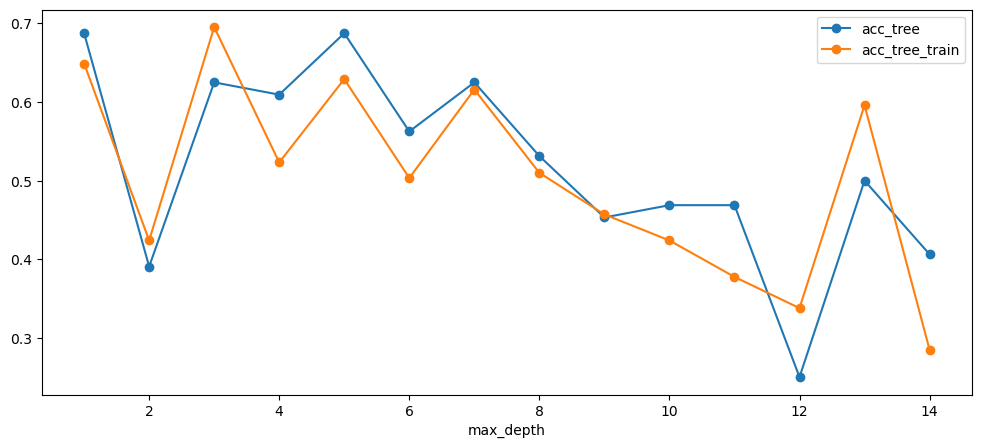

In [143]:
metrics_df.plot(figsize=(12, 5), marker="o")

# Implement with scikit learn

In [144]:
y = df['status']
X = df.drop('status', axis=1)

In [145]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=50)

In [146]:
X_train.shape ,X_test.shape

((193, 9), (22, 9))

In [147]:
y_train.head()

12     Not Placed
89         Placed
165    Not Placed
119        Placed
34     Not Placed
Name: status, dtype: object

In [148]:
X_train.head()

,ssc_percentage,hsc_percentage,hsc_subject,degree_percentage,undergrad_degree,work_experience,emp_test_percentage,specialisation,mba_percent
12,47.0,55.00,Science,65.0,Comm&Mgmt,No,62.00,Mkt&HR,65.04
89,84.0,75.00,Science,69.0,Sci&Tech,Yes,62.00,Mkt&HR,62.36
165,63.3,78.33,Commerce,74.0,Comm&Mgmt,No,80.00,Mkt&Fin,74.56
119,60.8,68.40,Commerce,64.6,Comm&Mgmt,Yes,82.66,Mkt&Fin,64.34
34,62.0,51.00,Science,52.0,Others,No,68.44,Mkt&HR,62.77


In [149]:
import category_encoders as ce

In [150]:
encoder = ce.OrdinalEncoder(cols=['work_experience','hsc_subject','undergrad_degree','specialisation'])

X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [151]:
X_train.head()

,ssc_percentage,hsc_percentage,hsc_subject,degree_percentage,undergrad_degree,work_experience,emp_test_percentage,specialisation,mba_percent
12,47.0,55.00,1,65.0,1,1,62.00,1,65.04
89,84.0,75.00,1,69.0,2,2,62.00,1,62.36
165,63.3,78.33,2,74.0,1,1,80.00,2,74.56
119,60.8,68.40,2,64.6,1,2,82.66,2,64.34
34,62.0,51.00,1,52.0,3,1,68.44,1,62.77


In [152]:
X_test.head()

,ssc_percentage,hsc_percentage,hsc_subject,degree_percentage,undergrad_degree,work_experience,emp_test_percentage,specialisation,mba_percent
146,62.00,63.00,1,66.00,1,1,85.00,1,55.14
73,64.60,83.83,2,71.72,1,1,86.00,2,59.75
121,64.00,67.00,1,69.60,2,2,55.67,1,71.49
1,79.33,78.33,1,77.48,2,2,86.50,2,66.28
23,77.40,60.00,1,64.74,2,2,92.00,2,63.62


In [153]:
clf_entropy = DecisionTreeClassifier(criterion='entropy',max_depth=3, random_state=0)


clf_entropy.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

In [154]:
y_pred_entropy = clf_entropy.predict(X_test)

Checking Accuracy with entropy index

In [155]:
from sklearn.metrics import accuracy_score

print('model accuracy score with criterion entropy: {0:0.4f}'.format(accuracy_score(y_test, y_pred_entropy)))

model accuracy score with criterion entropy: 0.9545


In [156]:
y_pred_train_entropy = clf_entropy.predict(X_train)

y_pred_train_entropy

array(['Not Placed', 'Placed', 'Placed', 'Placed', 'Not Placed',
       'Not Placed', 'Placed', 'Placed', 'Placed', 'Placed', 'Placed',
       'Placed', 'Placed', 'Placed', 'Placed', 'Placed', 'Placed',
       'Placed', 'Placed', 'Placed', 'Placed', 'Not Placed', 'Placed',
       'Placed', 'Placed', 'Placed', 'Placed', 'Placed', 'Not Placed',
       'Placed', 'Placed', 'Placed', 'Placed', 'Not Placed', 'Placed',
       'Placed', 'Placed', 'Placed', 'Not Placed', 'Placed', 'Placed',
       'Placed', 'Placed', 'Placed', 'Not Placed', 'Not Placed', 'Placed',
       'Placed', 'Placed', 'Placed', 'Not Placed', 'Placed', 'Placed',
       'Placed', 'Not Placed', 'Placed', 'Placed', 'Placed', 'Placed',
       'Placed', 'Not Placed', 'Placed', 'Placed', 'Placed', 'Placed',
       'Not Placed', 'Placed', 'Placed', 'Placed', 'Not Placed',
       'Not Placed', 'Not Placed', 'Placed', 'Not Placed', 'Placed',
       'Placed', 'Placed', 'Not Placed', 'Placed', 'Placed', 'Not Placed',
       'Placed',

In [157]:
print('training set accuracy score : {0:0.4f}'.format(accuracy_score(y_train,y_pred_train_entropy)))

training set accuracy score : 0.8549


In [158]:
print('Training set score: {:.4f}'.format(clf_entropy.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(clf_entropy.score(X_test, y_test)))

Training set score: 0.8549
Test set score: 0.9545


[Text(0.5, 0.875, 'x[0] <= 63.7\nentropy = 0.911\nsamples = 193\nvalue = [63, 130]'),
 Text(0.2, 0.625, 'x[1] <= 58.5\nentropy = 0.931\nsamples = 78\nvalue = [51, 27]'),
 Text(0.1, 0.375, 'entropy = 0.0\nsamples = 27\nvalue = [27, 0]'),
 Text(0.3, 0.375, 'x[0] <= 55.34\nentropy = 0.998\nsamples = 51\nvalue = [24, 27]'),
 Text(0.2, 0.125, 'entropy = 0.75\nsamples = 14\nvalue = [11, 3]'),
 Text(0.4, 0.125, 'entropy = 0.935\nsamples = 37\nvalue = [13, 24]'),
 Text(0.8, 0.625, 'x[1] <= 71.99\nentropy = 0.483\nsamples = 115\nvalue = [12, 103]'),
 Text(0.7, 0.375, 'x[8] <= 58.275\nentropy = 0.672\nsamples = 68\nvalue = [12, 56]'),
 Text(0.6, 0.125, 'entropy = 0.0\nsamples = 18\nvalue = [0, 18]'),
 Text(0.8, 0.125, 'entropy = 0.795\nsamples = 50\nvalue = [12, 38]'),
 Text(0.9, 0.375, 'entropy = 0.0\nsamples = 47\nvalue = [0, 47]')]

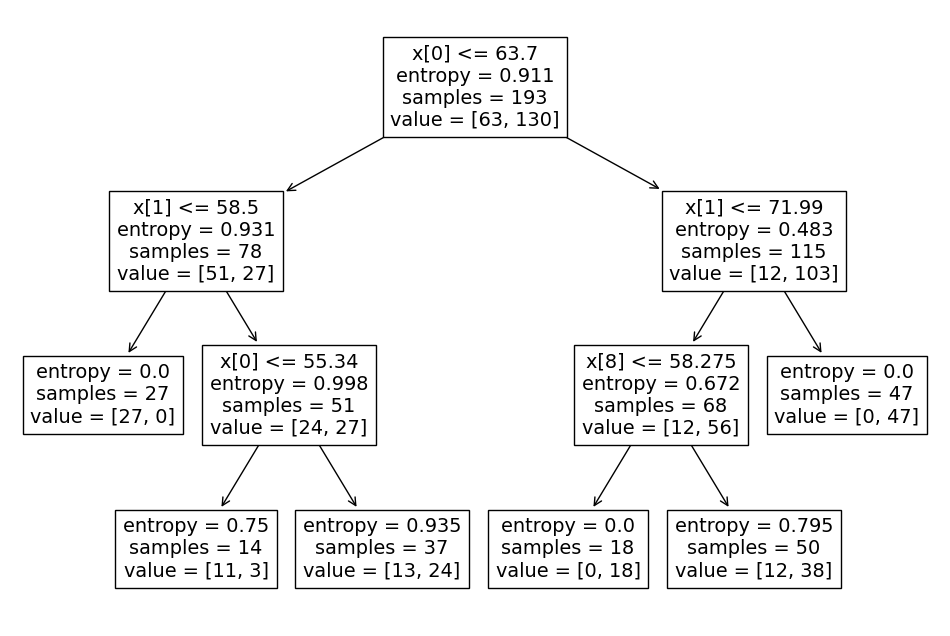

In [159]:
plt.figure(figsize=(12,8))

from sklearn import tree

tree.plot_tree(clf_entropy.fit(X_train,y_train))

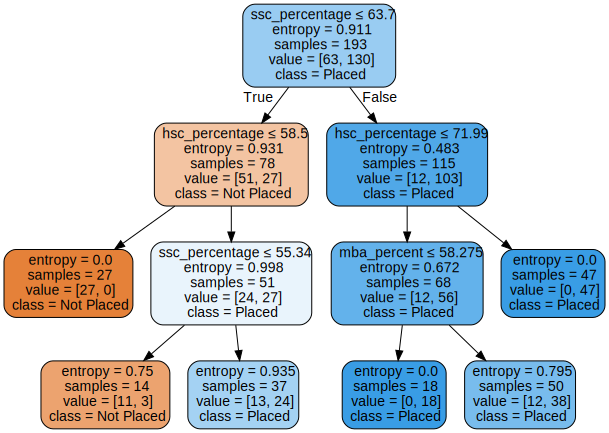

In [ ]:
import graphviz 
dot_data = tree.export_graphviz(clf_entropy, out_file=None, 
                              feature_names=X_train.columns,  
                              class_names=y_train,  
                              filled=True, rounded=True,  
                              special_characters=True)

graph = graphviz.Source(dot_data) 

graph 